In [3]:
import tensorflow as tf
from tensorflow import keras

import os
import tempfile

import matplotlib as mpl
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns

import sklearn
from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import warnings
warnings.filterwarnings('always')

In [2]:
mpl.rcParams['figure.figsize'] = (12, 10)
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']

In [4]:
file = tf.keras.utils
raw_df = pd.read_csv('../Dataset/kendaraan_test_clean.csv')
raw_df.head()

,Jenis_Kelamin,Umur,SIM,Kode_Daerah,Sudah_Asuransi,Umur_Kendaraan,Kendaraan_Rusak,Premi,Kanal_Penjualan,Lama_Berlangganan,Tertarik
0,0,0.446154,1,0.153846,0,1,1,0.762108,0.154321,0.467128,0
1,1,0.030769,1,0.903846,1,0,0,0.625240,0.932099,0.799308,0
2,1,0.061538,1,0.538462,1,0,0,1.946644,0.932099,0.179931,0
3,1,0.400000,1,0.153846,1,1,0,0.562615,0.759259,0.083045,0
4,1,0.230769,1,0.442308,0,1,1,0.389120,0.932099,0.757785,0


In [5]:
neg, pos = np.bincount(raw_df['Tertarik'])
total = neg + pos
print('Examples:\n    Total: {}\n    Positive: {} ({:.2f}% of total)\n'.format(
    total, pos, 100 * pos / total))

Examples:
    Total: 47639
    Positive: 5861 (12.30% of total)



In [7]:
# Use a utility from sklearn to split and shuffle your dataset.
train_df, test_df = train_test_split(raw_df, test_size=0.2)
train_df, val_df = train_test_split(train_df, test_size=0.2)

# Form np arrays of labels and features.
train_labels = np.array(train_df.pop('Tertarik'))
bool_train_labels = train_labels != 0
val_labels = np.array(val_df.pop('Tertarik'))
test_labels = np.array(test_df.pop('Tertarik'))

train_features = np.array(train_df)
val_features = np.array(val_df)
test_features = np.array(test_df)


In [8]:
scaler = StandardScaler()
train_features = scaler.fit_transform(train_features)

val_features = scaler.transform(val_features)
test_features = scaler.transform(test_features)

train_features = np.clip(train_features, -5, 5)
val_features = np.clip(val_features, -5, 5)
test_features = np.clip(test_features, -5, 5)


print('Training labels shape:', train_labels.shape)
print('Validation labels shape:', val_labels.shape)
print('Test labels shape:', test_labels.shape)

print('Training features shape:', train_features.shape)
print('Validation features shape:', val_features.shape)
print('Test features shape:', test_features.shape)

Training labels shape: (30488,)
Validation labels shape: (7623,)
Test labels shape: (9528,)
Training features shape: (30488, 10)
Validation features shape: (7623, 10)
Test features shape: (9528, 10)


In [9]:
METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'), 
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense(
          16, activation='relu',
          input_shape=(train_features.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model

2021-11-17 20:07:19.351075: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:939] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-11-17 20:07:19.352083: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory
2021-11-17 20:07:19.352508: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublas.so.11'; dlerror: libcublas.so.11: cannot open shared object file: No such file or directory
2021-11-17 20:07:19.352722: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcublasLt.so.11'; dlerror: libcublasLt.so.11: cannot open shared object file: No such file or directory
2021-11-17 20:07:19.397851: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Co

In [10]:
EPOCHS = 100
BATCH_SIZE = 2048

early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_prc', 
    verbose=1,
    patience=10,
    mode='max',
    restore_best_weights=True)

In [11]:
model = make_model()
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 16)                176       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_1 (Dense)             (None, 1)                 17        
                                                                 
Total params: 193
Trainable params: 193
Non-trainable params: 0
_________________________________________________________________


In [12]:
model.predict(train_features[:10])

array([[0.25413358],
       [0.14415884],
       [0.14555505],
       [0.09034622],
       [0.43876606],
       [0.23621872],
       [0.35055655],
       [0.5414087 ],
       [0.47934192],
       [0.48803246]], dtype=float32)

In [13]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.4225


In [14]:
initial_bias = np.log([pos/neg])
initial_bias

array([-1.96404965])

In [15]:
model = make_model(output_bias=initial_bias)
model.predict(train_features[:10])

array([[0.08871058],
       [0.07560903],
       [0.0542607 ],
       [0.04920307],
       [0.1645321 ],
       [0.13603747],
       [0.32579058],
       [0.2898272 ],
       [0.21123621],
       [0.18857595]], dtype=float32)

In [16]:
results = model.evaluate(train_features, train_labels, batch_size=BATCH_SIZE, verbose=0)
print("Loss: {:0.4f}".format(results[0]))

Loss: 0.3590


In [17]:
initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [18]:
model = make_model()
model.load_weights(initial_weights)
model.layers[-1].bias.assign([0.0])
zero_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [19]:
model = make_model()
model.load_weights(initial_weights)
careful_bias_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=20,
    validation_data=(val_features, val_labels), 
    verbose=0)

In [20]:
def plot_loss(history, label, n):
  # Use a log scale on y-axis to show the wide range of values.
  plt.semilogy(history.epoch, history.history['loss'],
               color=colors[n], label='Train ' + label)
  plt.semilogy(history.epoch, history.history['val_loss'],
               color=colors[n], label='Val ' + label,
               linestyle="--")
  plt.xlabel('Epoch')
  plt.ylabel('Loss')

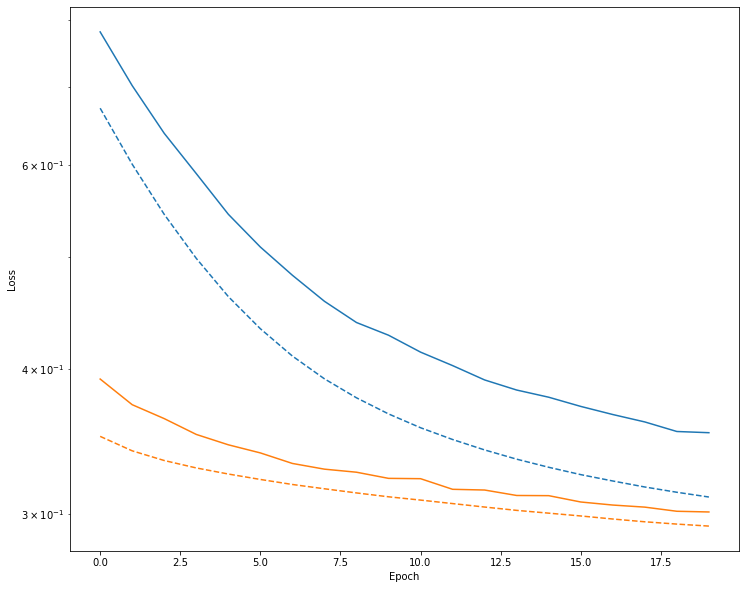

In [21]:
plot_loss(zero_bias_history, "Zero Bias", 0)
plot_loss(careful_bias_history, "Careful Bias", 1)

In [22]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels))

Epoch 1/100
15/15 [==============================] - 5s 159ms/step - loss: 0.3926 - tp: 252.0000 - fp: 1170.0000 - tn: 32240.0000 - fn: 4449.0000 - accuracy: 0.8526 - precision: 0.1772 - recall: 0.0536 - auc: 0.6762 - prc: 0.1818 - val_loss: 0.3502 - val_tp: 5.0000 - val_fp: 18.0000 - val_tn: 6636.0000 - val_fn: 964.0000 - val_accuracy: 0.8712 - val_precision: 0.2174 - val_recall: 0.0052 - val_auc: 0.7204 - val_prc: 0.2185
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 0.3743 - tp: 195.0000 - fp: 882.0000 - tn: 25874.0000 - fn: 3537.0000 - accuracy: 0.8551 - precision: 0.1811 - recall: 0.0523 - auc: 0.6614 - prc: 0.1766 - val_loss: 0.3405 - val_tp: 1.0000 - val_fp: 4.0000 - val_tn: 6650.0000 - val_fn: 968.0000 - val_accuracy: 0.8725 - val_precision: 0.2000 - val_recall: 0.0010 - val_auc: 0.7423 - val_prc: 0.2309
Epoch 3/100
15/15 [==============================] - 0s 17ms/step - loss: 0.3605 - tp: 152.0000 - fp: 607.0000 - tn: 26149.0000 - fn: 3580.0000 - acc

In [23]:
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

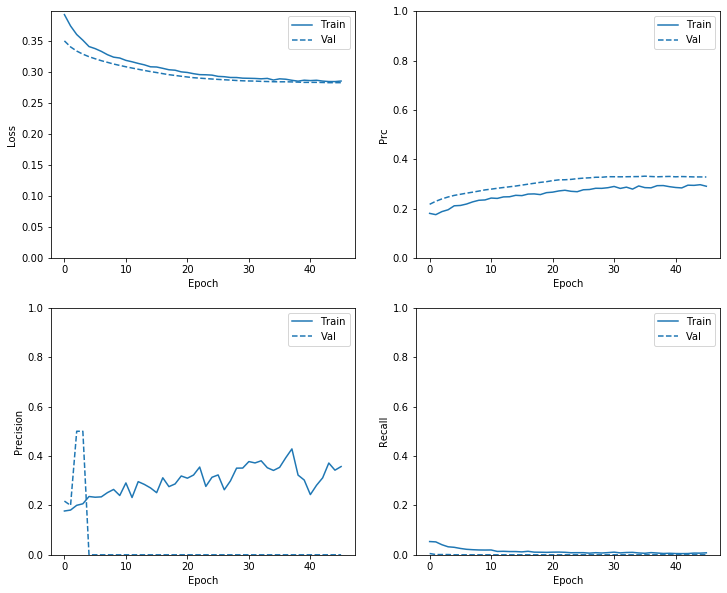

In [24]:
plot_metrics(baseline_history)

In [25]:
train_predictions_baseline = model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_baseline = model.predict(test_features, batch_size=BATCH_SIZE)

In [26]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Confusion matrix @{:.2f}'.format(p))
  plt.ylabel('Actual label')
  plt.xlabel('Predicted label')

  print('Legitimate Transactions Detected (True Negatives): ', cm[0][0])
  print('Legitimate Transactions Incorrectly Detected (False Positives): ', cm[0][1])
  print('Fraudulent Transactions Missed (False Negatives): ', cm[1][0])
  print('Fraudulent Transactions Detected (True Positives): ', cm[1][1])
  print('Total Fraudulent Transactions: ', np.sum(cm[1]))

loss :  0.2777862846851349
tp :  0.0
fp :  0.0
tn :  8368.0
fn :  1160.0
accuracy :  0.8782535791397095
precision :  0.0
recall :  0.0
auc :  0.8309224843978882
prc :  0.3061468303203583

Legitimate Transactions Detected (True Negatives):  8368
Legitimate Transactions Incorrectly Detected (False Positives):  0
Fraudulent Transactions Missed (False Negatives):  1160
Fraudulent Transactions Detected (True Positives):  0
Total Fraudulent Transactions:  1160


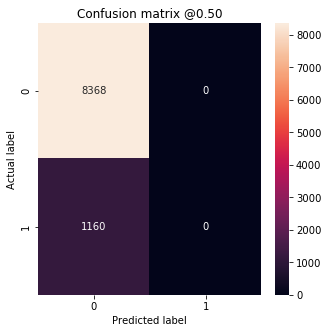

In [27]:
baseline_results = model.evaluate(test_features, test_labels,
                                  batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(model.metrics_names, baseline_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_baseline)

In [39]:
def plot_prc(name, labels, predictions, **kwargs):
    precision, recall, _ = sklearn.metrics.precision_recall_curve(labels, predictions)

    plt.plot(precision, recall, label=name, linewidth=2, **kwargs)
    plt.xlabel('Recall')
    plt.ylabel('Precision')
    plt.grid(True)
    ax = plt.gca()
    ax.set_aspect('equal')

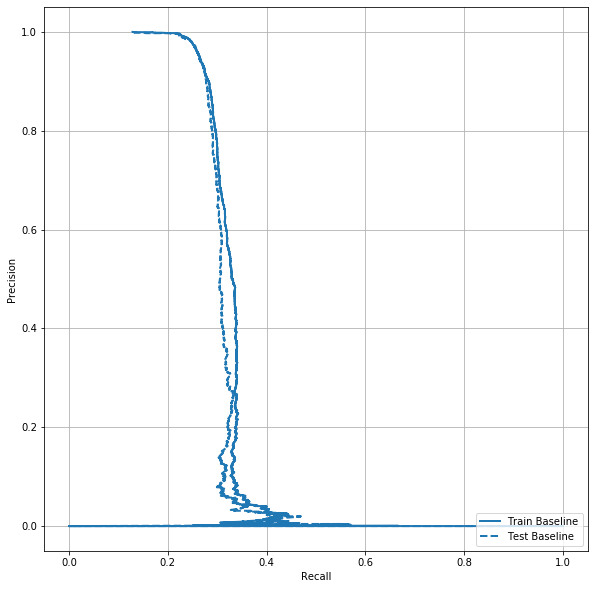

In [40]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')
plt.legend(loc='lower right')

In [41]:
# Scaling by total/2 helps keep the loss to a similar magnitude.
# The sum of the weights of all examples stays the same.
weight_for_0 = (1 / neg) * (total / 2.0)
weight_for_1 = (1 / pos) * (total / 2.0)

class_weight = {0: weight_for_0, 1: weight_for_1}

print('Weight for class 0: {:.2f}'.format(weight_for_0))
print('Weight for class 1: {:.2f}'.format(weight_for_1))

Weight for class 0: 0.57
Weight for class 1: 4.06


In [42]:
weighted_model = make_model()
weighted_model.load_weights(initial_weights)

weighted_history = weighted_model.fit(
    train_features,
    train_labels,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_features, val_labels),
    # The class weights go here
    class_weight=class_weight)

Epoch 1/100
15/15 [==============================] - 6s 196ms/step - loss: 0.9473 - tp: 333.0000 - fp: 1629.0000 - tn: 33495.0000 - fn: 4559.0000 - accuracy: 0.8454 - precision: 0.1697 - recall: 0.0681 - auc: 0.6797 - prc: 0.1800 - val_loss: 0.3666 - val_tp: 42.0000 - val_fp: 131.0000 - val_tn: 6523.0000 - val_fn: 927.0000 - val_accuracy: 0.8612 - val_precision: 0.2428 - val_recall: 0.0433 - val_auc: 0.7058 - val_prc: 0.2129
Epoch 2/100
15/15 [==============================] - 0s 16ms/step - loss: 0.8904 - tp: 506.0000 - fp: 2118.0000 - tn: 24638.0000 - fn: 3226.0000 - accuracy: 0.8247 - precision: 0.1928 - recall: 0.1356 - auc: 0.6476 - prc: 0.1755 - val_loss: 0.3719 - val_tp: 85.0000 - val_fp: 256.0000 - val_tn: 6398.0000 - val_fn: 884.0000 - val_accuracy: 0.8505 - val_precision: 0.2493 - val_recall: 0.0877 - val_auc: 0.7214 - val_prc: 0.2219
Epoch 3/100
15/15 [==============================] - 0s 17ms/step - loss: 0.8435 - tp: 662.0000 - fp: 2663.0000 - tn: 24093.0000 - fn: 3070.000

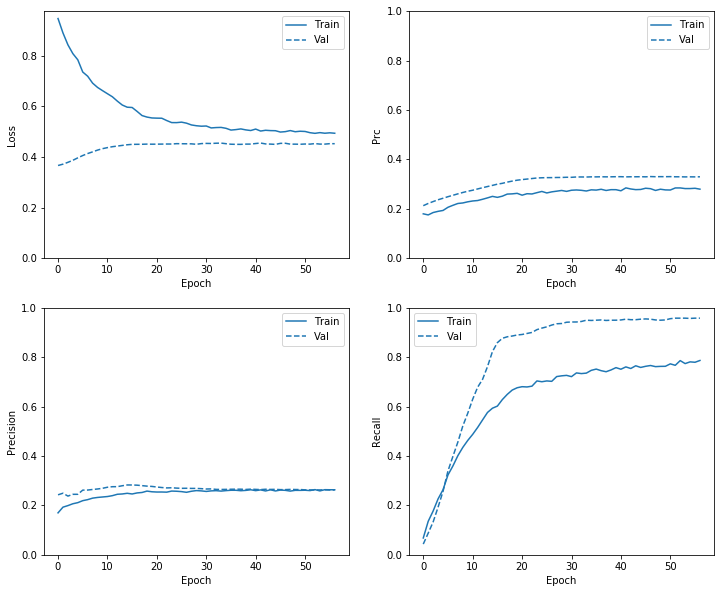

In [43]:
plot_metrics(weighted_history)

In [44]:
train_predictions_weighted = weighted_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_weighted = weighted_model.predict(test_features, batch_size=BATCH_SIZE)

loss :  0.45967504382133484
tp :  1110.0
fp :  3236.0
tn :  5132.0
fn :  50.0
accuracy :  0.6551217436790466
precision :  0.25540727376937866
recall :  0.9568965435028076
auc :  0.8296261429786682
prc :  0.30289632081985474

Legitimate Transactions Detected (True Negatives):  5132
Legitimate Transactions Incorrectly Detected (False Positives):  3236
Fraudulent Transactions Missed (False Negatives):  50
Fraudulent Transactions Detected (True Positives):  1110
Total Fraudulent Transactions:  1160


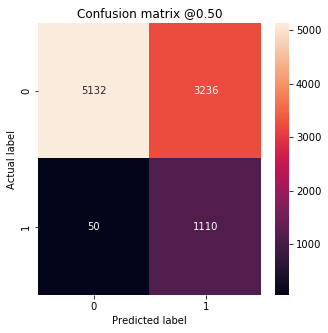

In [45]:
weighted_results = weighted_model.evaluate(test_features, test_labels,
                                           batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(weighted_model.metrics_names, weighted_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_weighted)

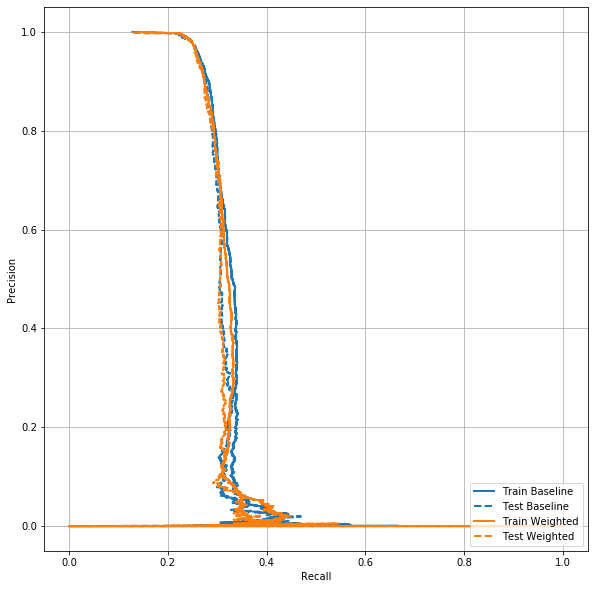

In [46]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')


plt.legend(loc='lower right')

In [47]:
pos_features = train_features[bool_train_labels]
neg_features = train_features[~bool_train_labels]

pos_labels = train_labels[bool_train_labels]
neg_labels = train_labels[~bool_train_labels]

In [48]:
ids = np.arange(len(pos_features))
choices = np.random.choice(ids, len(neg_features))

res_pos_features = pos_features[choices]
res_pos_labels = pos_labels[choices]

res_pos_features.shape

(26756, 10)

In [49]:
resampled_features = np.concatenate([res_pos_features, neg_features], axis=0)
resampled_labels = np.concatenate([res_pos_labels, neg_labels], axis=0)

order = np.arange(len(resampled_labels))
np.random.shuffle(order)
resampled_features = resampled_features[order]
resampled_labels = resampled_labels[order]

resampled_features.shape

(53512, 10)

In [51]:
BUFFER_SIZE = 100000

def make_ds(features, labels):
  ds = tf.data.Dataset.from_tensor_slices((features, labels))#.cache()
  ds = ds.shuffle(BUFFER_SIZE).repeat()
  return ds

pos_ds = make_ds(pos_features, pos_labels)
neg_ds = make_ds(neg_features, neg_labels)

In [52]:
for features, label in pos_ds.take(1):
  print("Features:\n", features.numpy())
  print()
  print("Label: ", label.numpy())

Features:
 [-1.07886871  0.59356453  0.04477497 -0.85820163 -0.91818633  0.69232826
  0.99124795  0.07285609  0.21771013 -1.18011084]

Label:  1


In [54]:
resampled_ds = tf.data.Dataset.sample_from_datasets([pos_ds, neg_ds], weights=[0.5, 0.5])
resampled_ds = resampled_ds.batch(BATCH_SIZE).prefetch(2)

In [55]:
for features, label in resampled_ds.take(1):
  print(label.numpy().mean())

0.50244140625


In [56]:
resampled_steps_per_epoch = np.ceil(2.0*neg/BATCH_SIZE)
resampled_steps_per_epoch

41.0

In [58]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

val_ds = tf.data.Dataset.from_tensor_slices((val_features, val_labels)).cache()
val_ds = val_ds.batch(BATCH_SIZE).prefetch(2) 

resampled_history = resampled_model.fit(
    resampled_ds,
    epochs=EPOCHS,
    steps_per_epoch=resampled_steps_per_epoch,
    callbacks=[early_stopping],
    validation_data=val_ds)

Epoch 1/100
41/41 [==============================] - 14s 216ms/step - loss: 0.6658 - tp: 52969.0000 - fp: 29003.0000 - tn: 39641.0000 - fn: 15603.0000 - accuracy: 0.6749 - precision: 0.6462 - recall: 0.7725 - auc: 0.7333 - prc: 0.6609 - val_loss: 0.6175 - val_tp: 809.0000 - val_fp: 2649.0000 - val_tn: 4005.0000 - val_fn: 160.0000 - val_accuracy: 0.6315 - val_precision: 0.2340 - val_recall: 0.8349 - val_auc: 0.7591 - val_prc: 0.2408
Epoch 2/100
41/41 [==============================] - 8s 198ms/step - loss: 0.6037 - tp: 29241.0000 - fp: 15813.0000 - tn: 25981.0000 - fn: 12933.0000 - accuracy: 0.6577 - precision: 0.6490 - recall: 0.6933 - auc: 0.7203 - prc: 0.6553 - val_loss: 0.5598 - val_tp: 832.0000 - val_fp: 2478.0000 - val_tn: 4176.0000 - val_fn: 137.0000 - val_accuracy: 0.6570 - val_precision: 0.2514 - val_recall: 0.8586 - val_auc: 0.7838 - val_prc: 0.2586
Epoch 3/100
41/41 [==============================] - 7s 175ms/step - loss: 0.5685 - tp: 31028.0000 - fp: 14985.0000 - tn: 27098.0

KeyboardInterrupt: 

In [ ]:
plot_metrics(resampled_history)

In [ ]:
resampled_model = make_model()
resampled_model.load_weights(initial_weights)

# Reset the bias to zero, since this dataset is balanced.
output_layer = resampled_model.layers[-1] 
output_layer.bias.assign([0])

resampled_history = resampled_model.fit(
    resampled_ds,
    # These are not real epochs
    steps_per_epoch=20,
    epochs=10*EPOCHS,
    callbacks=[early_stopping],
    validation_data=(val_ds))

In [ ]:
plot_metrics(resampled_history)

In [ ]:
train_predictions_resampled = resampled_model.predict(train_features, batch_size=BATCH_SIZE)
test_predictions_resampled = resampled_model.predict(test_features, batch_size=BATCH_SIZE)

In [ ]:
resampled_results = resampled_model.evaluate(test_features, test_labels,
                                             batch_size=BATCH_SIZE, verbose=0)
for name, value in zip(resampled_model.metrics_names, resampled_results):
  print(name, ': ', value)
print()

plot_cm(test_labels, test_predictions_resampled)

In [ ]:
plot_prc("Train Baseline", train_labels, train_predictions_baseline, color=colors[0])
plot_prc("Test Baseline", test_labels, test_predictions_baseline, color=colors[0], linestyle='--')

plot_prc("Train Weighted", train_labels, train_predictions_weighted, color=colors[1])
plot_prc("Test Weighted", test_labels, test_predictions_weighted, color=colors[1], linestyle='--')

plot_prc("Train Resampled", train_labels, train_predictions_resampled, color=colors[2])
plot_prc("Test Resampled", test_labels, test_predictions_resampled, color=colors[2], linestyle='--')
plt.legend(loc='lower right')